In [1]:
# ------------------------
## ----import libraries
# ------------------------
import os,sys
import numpy as np
# xarray
import xarray as xr
# plot
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.cm as cm
import matplotlib.ticker as mticker
from matplotlib.colors import Colormap
from matplotlib.colors import from_levels_and_colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import cmocean as ccm


In [2]:
from dask.distributed import Client
c = Client()
c

/linkhome/rech/genlop01/uor98hu/.local/lib/python3.9/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35283 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:35283/status,
Dashboard: http://127.0.0.1:35283/status,Workers: 5
Total threads: 10,Total memory: 20.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41661,Workers: 5
Dashboard: http://127.0.0.1:35283/status,Total threads: 10
Started: Just now,Total memory: 20.00 GiB
Comm: tcp://127.0.0.1:38371,Total threads: 2
Dashboard: http://127.0.0.1:33439/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:37831,


In [3]:
y1='2005'
y2='2018'

# plot directory
diro = "/gpfsscratch/rech/cli/uor98hu/PLOTS/"

In [4]:
# read grid files
diri="/gpfswork/rech/cli/rcli002/eORCA025.L75/eORCA025.L75-I/"
mesh =  xr.open_dataset(diri+'mesh_hgr.nc').squeeze()
tmask = mesh['tmask'][0,:,:] # grille lat/lon
nav_lon = mesh['nav_lon']
nav_lat = mesh['nav_lat']
e1t = mesh.e1t
e2t = mesh.e2t

cellArea= e1t * e2t 
mbathy = xr.open_dataset(diri+'eORCA025.L75_domain_cfg_closed_seas_greenland.nc')['bathy_meter'].isel(t=0) # grille lat/lon

BGRmask = xr.open_dataset('/gpfswork/rech/cli/uor98hu/MYDATA/TRANSPORT_WP1/BGRmaskobs.nc').BGRmask.squeeze()
# default gridlines parameters
gridl=False
incrgridlon=30
incrgridlat=10

# vue N.Atl
# loncentr=330 # before it was zero
# latcentr=70

#vue polaire
loncentr=200 # before it was zero
latcentr=90

sath=2085831


In [5]:
WeightBGR = cellArea.where(BGRmask, drop=True) / cellArea.where(BGRmask, drop=True).sum()

In [6]:
Fullmask = xr.open_dataset('/gpfswork/rech/cli/uor98hu/MYDATA/remoteGr_mask/Arctic_Grfull_mask.nc').polymask.squeeze()
WeightArctic = cellArea.where(Fullmask, drop=True) / cellArea.where(Fullmask, drop=True).sum()


## prop rivers in SLA

In [8]:
slaTrGAI_AI = xr.open_dataset('/gpfswork/rech/cli/uor98hu/MYDATA/SSH/eORCA025.L75-IMHOTEP._y2005_2018.1y_trendGAI_AIGMSLcorrected.nc').trend
slaTrAI_S = xr.open_dataset('/gpfswork/rech/cli/uor98hu/MYDATA/SSH/eORCA025.L75-IMHOTEP._y2005_2018.1y_trendS_AIGMSLcorrected.nc').trend *(-1)
slaTrGAI_S = slaTrGAI_AI + slaTrAI_S

In [12]:
# proportion de SLA Gr+Riv controlée par GREENLAND et par RIVERS
slaTrGAI_Sprop = abs(slaTrGAI_AI) + abs(slaTrAI_S)
propRIVERS = ((abs(slaTrAI_S)/slaTrGAI_Sprop)*100).where(nav_lat>60)
propGREENLAND = ((abs(slaTrGAI_AI)/slaTrGAI_Sprop)*100).where(nav_lat>60)

In [13]:
# in the BGR box
meanBGRboxpropRIVERS = (propRIVERS.where(BGRmask, drop=True) * WeightBGR).sum()
# in the whole Arctic box
meanArcticpropRIVERS = (propRIVERS.where(Fullmask, drop=True) * WeightArctic ).sum()

print(meanBGRboxpropRIVERS.values)
print(meanArcticpropRIVERS.values)

61.63314465846855
44.94686068631565


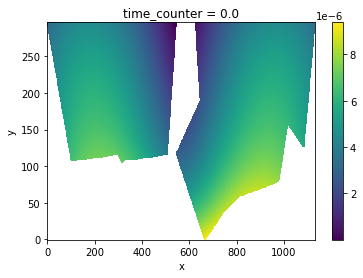

In [22]:
WeightArctic.plot()

## Prop steric in SLA

In [9]:
# load data
prof = "bottom"
decomposition = "steric" 
pathuna12nf = '/gpfswork/rech/cli/uor98hu/MYDATA/SLdecomposition_WP1/una12nf/'
TrGAI = xr.open_dataset(pathuna12nf+'GAI/'+decomposition+'/eORCA025.L75-IMHOTEP.GAI_y'+y1+'_'+y2+'.1y_'+decomposition+'_0_'+prof+'trend.nc').trend
TrAI = xr.open_dataset(pathuna12nf+'AI/'+decomposition+'/eORCA025.L75-IMHOTEP.AI_y'+y1+'_'+y2+'.1y_'+decomposition+'_0_'+prof+'trend.nc').trend
TrS = xr.open_dataset(pathuna12nf+'S/'+decomposition+'/eORCA025.L75-IMHOTEP.S_y'+y1+'_'+y2+'.1y_'+decomposition+'_0_'+prof+'trend.nc').trend

steTrGAI_S = TrGAI - TrS
steTrGAI_AI = TrGAI - TrAI
steTrAI_S = TrAI - TrS

manTrGAI_S  = slaTrGAI_S  - steTrGAI_S
manTrGAI_AI = slaTrGAI_AI - steTrGAI_AI
manTrAI_S   = slaTrAI_S   - steTrAI_S

In [10]:
###############------------- proportion de SLA Gr+Riv décidée par steric
slaTrGAI_Sprop = abs(steTrGAI_S) + abs(manTrGAI_S)
propSTEgrriv = ((abs(steTrGAI_S)/slaTrGAI_Sprop)*100).where(nav_lat>60)
# in the BGR box
meanBGRpropSTEgrriv = (propSTEgrriv.where(BGRmask, drop=True) * WeightBGR).sum()
# in the whole Arctic box
meanArcticpropSTEgrriv = (propSTEgrriv.where(Fullmask, drop=True) * WeightArctic).sum()


###############------------- proportion de SLA Gr décidée par steric
slaTrGAI_AIprop = abs(steTrGAI_AI) + abs(manTrGAI_AI)
propSTEGr = ((abs(steTrGAI_AI)/slaTrGAI_AIprop)*100).where(nav_lat>60)
# in the BGR box
meanBGRpropSTEgr = (propSTEGr.where(BGRmask, drop=True) * WeightBGR).sum()
# in the whole Arctic box
meanArcticpropSTEgr = (propSTEGr.where(Fullmask, drop=True) * WeightArctic).sum()

###############------------- proportion de SLA Riv décidée par steric
slaTrAI_Sprop = abs(steTrAI_S) + abs(manTrAI_S)
propSTERIV = ((abs(steTrAI_S)/slaTrAI_Sprop)*100).where(nav_lat>60)
# in the BGR box
meanBGRpropSTEriv = (propSTERIV.where(BGRmask, drop=True) * WeightBGR).sum()
# in the whole Arctic box
meanArcticpropSTEriv = (propSTERIV.where(Fullmask, drop=True) * WeightArctic).sum()

In [11]:
print("Gr+Riv")
print(meanBGRpropSTEgrriv.values)
print(meanArcticpropSTEgrriv.values)


print("Gr")
print(meanBGRpropSTEgr.values)
print(meanArcticpropSTEgr.values)


print("Riv")
print(meanBGRpropSTEriv.values)
print(meanArcticpropSTEriv.values)

print("mean(Gr+Riv, gr, riv)")
print(np.mean([meanBGRpropSTEgrriv.values,meanBGRpropSTEgr.values, meanBGRpropSTEriv.values]))
print(np.mean([meanArcticpropSTEgrriv.values, meanArcticpropSTEgr.values, meanArcticpropSTEriv.values]))

Gr+Riv
87.55252463178716
34.30177877386551
Gr
74.2194176966618
19.90452134063748
Riv
79.70684173740014
25.98786160993807
mean(Gr+Riv, gr, riv)
80.49292802194971
26.731387241480352


## proportion halosteric in steric

In [12]:
# load halostérique
prof = "bottom"
decomposition = "halosteric" 
pathuna12nf = '/gpfswork/rech/cli/uor98hu/MYDATA/SLdecomposition_WP1/una12nf/'
TrGAI = xr.open_dataset(pathuna12nf+'GAI/'+decomposition+'/eORCA025.L75-IMHOTEP.GAI_y'+y1+'_'+y2+'.1y_'+decomposition+'_0_'+prof+'trend.nc').trend
TrAI = xr.open_dataset(pathuna12nf+'AI/'+decomposition+'/eORCA025.L75-IMHOTEP.AI_y'+y1+'_'+y2+'.1y_'+decomposition+'_0_'+prof+'trend.nc').trend
TrS = xr.open_dataset(pathuna12nf+'S/'+decomposition+'/eORCA025.L75-IMHOTEP.S_y'+y1+'_'+y2+'.1y_'+decomposition+'_0_'+prof+'trend.nc').trend

halTrGAI_S = TrGAI - TrS
halTrGAI_AI = TrGAI - TrAI
halTrAI_S = TrAI - TrS

# load thermostérique
prof = "bottom"
decomposition = "thermosteric"
pathuna12nf = '/gpfswork/rech/cli/uor98hu/MYDATA/SLdecomposition_WP1/una12nf/'
TrGAI = xr.open_dataset(pathuna12nf+'GAI/'+decomposition+'/eORCA025.L75-IMHOTEP.GAI_y'+y1+'_'+y2+'.1y_'+decomposition+'_0_'+prof+'trend.nc').trend
TrAI = xr.open_dataset(pathuna12nf+'AI/'+decomposition+'/eORCA025.L75-IMHOTEP.AI_y'+y1+'_'+y2+'.1y_'+decomposition+'_0_'+prof+'trend.nc').trend
TrS = xr.open_dataset(pathuna12nf+'S/'+decomposition+'/eORCA025.L75-IMHOTEP.S_y'+y1+'_'+y2+'.1y_'+decomposition+'_0_'+prof+'trend.nc').trend

theTrGAI_S = TrGAI - TrS
theTrGAI_AI = TrGAI - TrAI
theTrAI_S = TrAI - TrS

In [13]:
###############------------- proportion de SLA Gr+Riv décidée par steric
steTrGAI_Sprop = abs(halTrGAI_S) + abs(theTrGAI_S)
propHALgrriv = ((abs(halTrGAI_S)/steTrGAI_Sprop)*100).where(nav_lat>60)
# in the BGR box
meanBGRpropHALgrriv = (propHALgrriv.where(BGRmask, drop=True) * WeightBGR).sum()
# in the whole Arctic box
meanArcticpropHALgrriv = (propHALgrriv.where(Fullmask, drop=True) * WeightArctic).sum()


###############------------- proportion de SLA Gr décidée par steric
steTrGAI_AIprop = abs(halTrGAI_AI) + abs(theTrGAI_AI)
propHALGr = ((abs(halTrGAI_AI)/steTrGAI_AIprop)*100).where(nav_lat>60)
# in the BGR box
meanBGRpropHALgr = (propHALGr.where(BGRmask, drop=True) * WeightBGR).sum()
# in the whole Arctic box
meanArcticpropHALgr = (propHALGr.where(Fullmask, drop=True) * WeightArctic).sum()

###############------------- proportion de SLA Riv décidée par steric
steTrAI_Sprop = abs(halTrAI_S) + abs(theTrAI_S)
propHALRIV = ((abs(halTrAI_S)/steTrAI_Sprop)*100).where(nav_lat>60)
# in the BGR box
meanBGRpropHALriv = (propHALRIV.where(BGRmask, drop=True) * WeightBGR).sum()
# in the whole Arctic box
meanArcticpropHALriv = (propHALRIV.where(Fullmask, drop=True) * WeightArctic).sum()

In [34]:
print("Gr+Riv")
print(meanBGRpropHALgrriv.values)
print(meanArcticpropHALgrriv.values)


print("Gr")
print(meanBGRpropHALgr.values)
print(meanArcticpropHALgr.values)


print("Riv")
print(meanBGRpropHALriv.values)
print(meanArcticpropHALriv.values)

print("mean(Gr+Riv, gr, riv)")
print(np.mean([meanBGRpropHALgrriv.values,meanBGRpropHALgr.values, meanBGRpropHALriv.values]))
print(np.mean([meanArcticpropHALgrriv.values, meanArcticpropHALgr.values, meanArcticpropHALriv.values]))

Gr+Riv
87.19223124062074
38.903184066780206
Gr
88.09208589418638
37.55501001259318
Riv
89.93341517065575
39.57455035118363
mean(Gr+Riv, gr, riv)
88.40591076848762
38.67758147685234
